In [22]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm

from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
import albumentations as A

In [23]:
import IPython.display as disp

In [24]:
warnings.filterwarnings('ignore')

In [74]:
EXP_NAME = "EXP_003_convnext-t_224_mult_albu"

WANDB_PROJECT = 'kaggle-corn-2022'

CSV_PATH = Path('/data/train.csv')
DATA_PATH = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


model_name = "convnext_tiny_in22ft1k"
global_pool = "catavgmax"
bsz = 32
input_sz = 224
drop_rate = 0.5
drop_path_rate = 0.1

loss_weights = [0.7, 0.3]

trn_aug = A.Compose([
    A.Resize(input_sz, input_sz),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.ShiftScaleRotate(rotate_limit=360, border_mode=0, p=0.5),
    #A.CoarseDropout(max_height=32, max_width=32, p=0.75),
])

crop_pct = 0.875
scale_size = int(math.floor(input_sz / 0.875))
val_aug = A.Compose([
    A.Resize(scale_size,scale_size), 
    A.CenterCrop(input_sz, input_sz)
])

In [75]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [76]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [77]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, trn_aug:A.Compose, val_aug:A.Compose): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0: aug_img = self.trn_aug(image=np.array(img))['image']
        else            : aug_img = self.val_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [78]:
def get_dls(fold:int, size:int, bs:int):
    
    aug_tfm = AlbumentationsTransform(trn_aug=trn_aug, val_aug=val_aug)
    item_tfms = [aug_tfm, ToTensor]
    batch_tfms = [IntToFloatTensor,Normalize.from_stats(*imagenet_stats)]
    
    getters = [
           ColReader('image', pref=DATA_PATH),
           ColReader('label'),
           ColReader('view')]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS), CategoryBlock(vocab=VIEWS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        getters    = getters,
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms,
        n_inp      = 1)
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

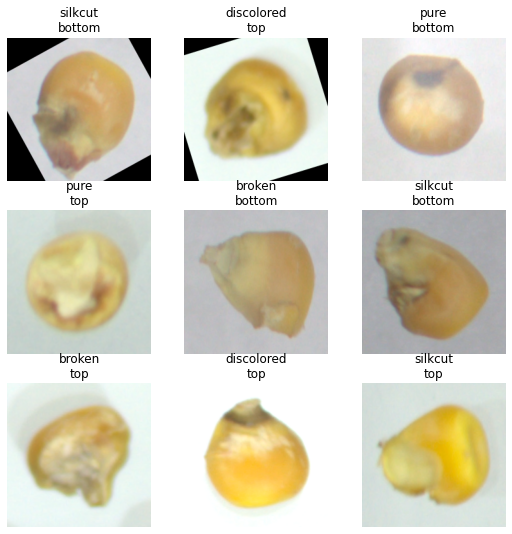

In [81]:
dls = get_dls(0, size=input_sz, bs=bsz)
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(ctxs=axs.flatten())

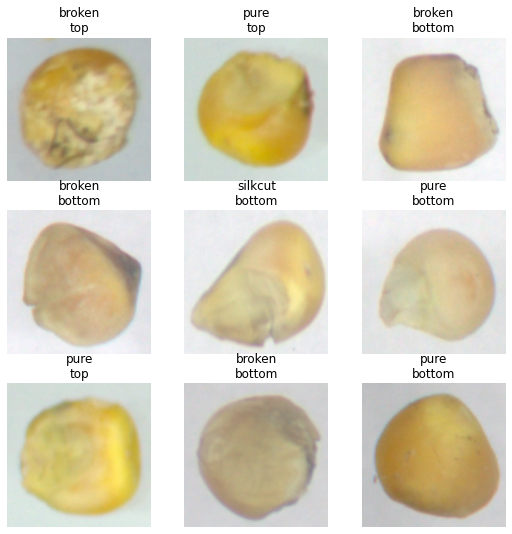

In [80]:
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.valid.show_batch(ctxs=axs.flatten())

In [83]:
class MultiHead(Module):
    def __init__(self, nf:int, n_out:L):
        store_attr()
        
        self.global_pool = SelectAdaptivePool2d(pool_type=global_pool, flatten=True)
        self.nf *= self.global_pool.feat_mult()
        
        self.label = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(self.nf, self.n_out[0]))
        self.view = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(self.nf, self.n_out[1]))
    
    def forward(self, x):
        y = self.global_pool(x)
        label = self.label(y)
        view = self.view(y)
        return [label, view]
        

class CornModel(Module):
    def __init__(self, n_out:L, pretrained:bool=True):
        
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            drop_path_rate=drop_path_rate,
            global_pool="",
            num_classes=0)
        
        if hasattr(self.model, 'head'):
            self.model.head = nn.Identity() 
        
        self.num_features = self.model.num_features
        
        self.head = MultiHead(self.num_features, n_out)
    
    def forward(self, x):        
        y = self.model.forward_features(x)        
        label, view = self.head(y)
        return [label, view]

In [84]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())

# def timm_params(timm_model, cut=-1):
#     body_param_names = timm_get_param_names(timm_model)
#     head_param_names = L(body_param_names.pop(-1)).concat()
    
#     body_param_names = L(body_param_names[:cut].concat(), body_param_names[cut:].concat())
#     return body_param_names, head_param_names

# def timm_splitter(m, cut=-1):
#     "Splitter function for timm models"
#     body_param_names, head_param_names = timm_params(m, cut)
#     param_groups = [g.map(m.get_parameter) for g in body_param_names]
#     param_groups.append([m.get_parameter(p) for p in head_param_names])
#     return param_groups

def get_splitter(m, cut=-1):
    body_param_names = timm_get_param_names(m.model)
    body_param_names = L(body_param_names[:cut].concat(), body_param_names[cut:].concat())
    param_groups = [g.map(m.model.get_parameter) for g in body_param_names]
    param_groups.append(params(m.head))
    return param_groups

def accuracy_label(inp, targ1, targ2, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ1)
    return (pred == targ).float().mean()


class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    y_int = True # y interpolation
    def __init__(self, losses=[CrossEntropyLossFlat(), CrossEntropyLossFlat()], weights=[2., 1.]):
        store_attr()
        assert len(self.losses) == len(self.weights)

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y, lf in zip(range(len(xs)), self.weights, xs, ys, self.losses):
            if i == 0: loss = w*lf(x, y) 
            else: loss += w*lf(x, y) 
        return loss/sum(self.weights)

In [85]:
@delegates(Learner)
def create_learner(dls, pretrained=True, **kwargs):
    
    set_fast_norm()
    model = CornModel(n_out=dls.c, pretrained=pretrained)
    
    learn = Learner(dls, model, **kwargs)    
    return learn

In [86]:
SUFFIX = "epo15_ft"

In [87]:
for fold_idx in range(5):
    set_seed(42); set_fast_norm()
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
        dls = get_dls(fold_idx, size=input_sz, bs=bsz)
        m = CornModel(n_out=dls.c, pretrained=True)
        
        loss_fn = CombinationLoss(dls.loss_func, weights=loss_weights)
        learn = create_learner(
            dls, pretrained=True, loss_func=loss_fn, splitter=partial(get_splitter, cut=-3),
            metrics=[accuracy_label], model_dir=Path("/runs/")).to_fp16()
        
        learn.fine_tune(15, 2e-03, cbs=[SaveModelCallback(monitor="accuracy_label", comp=np.greater)])

        learn = learn.load("model")
        learn = learn.to_fp32()

        learn.save(f"{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}", with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.443636,0.800112,0.552880,00:24


Better model found at epoch 0 with accuracy_label value: 0.5528795719146729.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.714987,0.491768,0.730890,00:33
1,0.567108,0.418579,0.760558,00:33
2,0.528996,0.513752,0.726702,00:33
3,0.528671,0.433827,0.767190,00:34
4,0.487188,0.447694,0.765445,00:33
5,0.443626,0.446935,0.746597,00:34
6,0.406069,0.380943,0.782199,00:33
7,0.357745,0.429683,0.783246,00:34
8,0.354757,0.387126,0.791274,00:33
9,0.331448,0.363720,0.797208,00:34


Better model found at epoch 0 with accuracy_label value: 0.7308900356292725.
Better model found at epoch 1 with accuracy_label value: 0.7605584859848022.
Better model found at epoch 3 with accuracy_label value: 0.7671902179718018.
Better model found at epoch 6 with accuracy_label value: 0.782198965549469.
Better model found at epoch 7 with accuracy_label value: 0.7832460999488831.
Better model found at epoch 8 with accuracy_label value: 0.7912740111351013.
Better model found at epoch 9 with accuracy_label value: 0.7972076535224915.
Better model found at epoch 13 with accuracy_label value: 0.8013961315155029.
CPU: 62/92/3732 MB | GPU: 42/2220/2410 MB | Time 0:09:01.613 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.498825,0.912659,0.534031,00:24


Better model found at epoch 0 with accuracy_label value: 0.5340313911437988.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.714382,0.490654,0.719023,00:33
1,0.599039,0.415593,0.757068,00:33
2,0.544726,0.408143,0.766841,00:34
3,0.494721,0.407591,0.773473,00:34
4,0.464216,0.402247,0.765096,00:34
5,0.438413,0.377909,0.787435,00:33
6,0.417899,0.358422,0.791274,00:33
7,0.397813,0.379743,0.782199,00:33
8,0.359755,0.386154,0.796161,00:34
9,0.352394,0.346339,0.812216,00:34


Better model found at epoch 0 with accuracy_label value: 0.7190226912498474.
Better model found at epoch 1 with accuracy_label value: 0.7570680379867554.
Better model found at epoch 2 with accuracy_label value: 0.7668411731719971.
Better model found at epoch 3 with accuracy_label value: 0.7734729647636414.
Better model found at epoch 5 with accuracy_label value: 0.7874345779418945.
Better model found at epoch 6 with accuracy_label value: 0.7912740111351013.
Better model found at epoch 8 with accuracy_label value: 0.7961605787277222.
Better model found at epoch 9 with accuracy_label value: 0.8122164011001587.
Better model found at epoch 13 with accuracy_label value: 0.8139616250991821.
Better model found at epoch 14 with accuracy_label value: 0.8143106698989868.
CPU: 9/85/3741 MB | GPU: 28/2172/2438 MB | Time 0:09:03.071 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.418452,0.827944,0.543296,00:24


Better model found at epoch 0 with accuracy_label value: 0.5432960987091064.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.717161,0.525504,0.694134,00:33
1,0.607903,0.553130,0.686802,00:34
2,0.516876,0.431155,0.754888,00:33
3,0.482569,0.494420,0.728352,00:34
4,0.467071,0.469119,0.765014,00:34
5,0.447080,0.386531,0.789455,00:34
6,0.388596,0.384855,0.785615,00:34
7,0.393914,0.368764,0.791899,00:34
8,0.364842,0.365794,0.799232,00:34
9,0.324481,0.392738,0.791201,00:34


Better model found at epoch 0 with accuracy_label value: 0.6941340565681458.
Better model found at epoch 2 with accuracy_label value: 0.7548882961273193.
Better model found at epoch 4 with accuracy_label value: 0.7650139927864075.
Better model found at epoch 5 with accuracy_label value: 0.7894552946090698.
Better model found at epoch 7 with accuracy_label value: 0.7918994426727295.
Better model found at epoch 8 with accuracy_label value: 0.7992318272590637.
Better model found at epoch 11 with accuracy_label value: 0.8076117038726807.
Better model found at epoch 13 with accuracy_label value: 0.8086591958999634.
CPU: 88/4/3829 MB | GPU: 40/2134/2478 MB | Time 0:09:02.864 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy_label,time
0,1.408753,1.029396,0.521648,00:24


Better model found at epoch 0 with accuracy_label value: 0.5216480493545532.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.732126,0.484934,0.717528,00:33
1,0.611655,0.517881,0.722416,00:34
2,0.555560,0.441702,0.759427,00:34
3,0.509283,0.403532,0.768156,00:34
4,0.460710,0.414769,0.766760,00:34
5,0.455946,0.453769,0.761173,00:34
6,0.421037,0.380212,0.782472,00:34
7,0.382938,0.389172,0.786662,00:34
8,0.357691,0.394786,0.786313,00:34
9,0.339440,0.358779,0.804469,00:34


Better model found at epoch 0 with accuracy_label value: 0.7175279259681702.
Better model found at epoch 1 with accuracy_label value: 0.7224162220954895.
Better model found at epoch 2 with accuracy_label value: 0.7594273686408997.
Better model found at epoch 3 with accuracy_label value: 0.7681564092636108.
Better model found at epoch 6 with accuracy_label value: 0.7824720740318298.
Better model found at epoch 7 with accuracy_label value: 0.7866619825363159.
Better model found at epoch 9 with accuracy_label value: 0.8044692873954773.
Better model found at epoch 10 with accuracy_label value: 0.8107541799545288.
Better model found at epoch 12 with accuracy_label value: 0.8131983280181885.
Better model found at epoch 13 with accuracy_label value: 0.8135474920272827.
Better model found at epoch 14 with accuracy_label value: 0.8145949840545654.
CPU: 9/4/3838 MB | GPU: 40/2100/2518 MB | Time 0:09:05.621 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID

epoch,train_loss,valid_loss,accuracy_label,time
0,1.419711,0.728127,0.609986,00:24


Better model found at epoch 0 with accuracy_label value: 0.6099860072135925.


epoch,train_loss,valid_loss,accuracy_label,time
0,0.725630,0.492438,0.722416,00:34
1,0.574789,0.462352,0.732542,00:34
2,0.531125,0.451934,0.747556,00:34
3,0.515021,0.403888,0.772346,00:34
4,0.505032,0.390914,0.787709,00:34
5,0.448976,0.392476,0.785265,00:34
6,0.428427,0.382959,0.791201,00:34
7,0.407606,0.384271,0.788408,00:33
8,0.375082,0.372336,0.790154,00:34
9,0.340154,0.374921,0.799232,00:34


Better model found at epoch 0 with accuracy_label value: 0.7224162220954895.
Better model found at epoch 1 with accuracy_label value: 0.7325419187545776.
Better model found at epoch 2 with accuracy_label value: 0.7475558519363403.
Better model found at epoch 3 with accuracy_label value: 0.7723463773727417.
Better model found at epoch 4 with accuracy_label value: 0.7877094745635986.
Better model found at epoch 6 with accuracy_label value: 0.791201114654541.
Better model found at epoch 9 with accuracy_label value: 0.7992318272590637.
Better model found at epoch 10 with accuracy_label value: 0.8048184514045715.
Better model found at epoch 12 with accuracy_label value: 0.8076117038726807.
Better model found at epoch 13 with accuracy_label value: 0.8107541799545288.
CPU: 104/4/3854 MB | GPU: 0/2114/2518 MB | Time 0:09:04.174 | (Consumed/Peaked/Used Total)


In [88]:
pattern = f"{EXP_NAME}_{SUFFIX}" + "_CV_{fold:02d}"
folds_val_score = []

with IPyExperimentsPytorch(cl_set_seed=42):
    for fold_index in range(5):
        checkpoint = pattern.format(fold=fold_index)

        dls = get_dls(fold_index, size=input_sz, bs=bsz)
        
        learn = create_learner(dls, pretrained=True, model_dir=Path("/runs/"), metrics=[accuracy_label],
                    loss_func=CombinationLoss([CrossEntropyLossFlat(), CrossEntropyLossFlat()], 
                                              weights=loss_weights))
        
        learn.load(checkpoint)
        dl = dls.valid
        
        tst_dl = dl.new()
        
        preds, targs = learn.get_preds(dl=tst_dl)
        acc = accuracy(preds[0], targs[0]).item()
        
        tst_dl_1 = dl.new()
        tst_dl.after_batch.add(hflip)
        
        tst_dl_2 = dl.new()
        tst_dl.after_batch.add(vflip)
        
        preds0, targs = learn.get_preds(dl=tst_dl)
        preds1, _ = learn.get_preds(dl=tst_dl_1)
        preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0[0]+preds1[0]+preds2[0])/3
        acc = accuracy(preds, targs[0]).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80489, 0.81745, 0.81006, 0.81494, 0.80971]
Avg: 0.81141
Std: 0.00439


In [103]:
!mkdir /runs/EXP_003/
!mv /runs/{EXP_NAME}_{SUFFIX}_CV_* /runs/EXP_003/